# Dance Form Classification

![](dance1.webp)

### Contents
* [**Abstract**](#abstract)
* [**Dataset**](#dataset)
* [**Importing Dataset and the required libraries**](#import)
* [**Exploring the dataset**](#explore)
* [**Dataset Distribution and Pre-processing**](#dist)
* [**Classification Algorithms**](#part-b)
    * [Feed Forward Neural Network](#feed)
    * [Transfer Learning Neural Network](#tf)
* [**Conclusion**](#conclusion)

<a id = 'abstract'></a>
### Abstract
Indian classical dance is the combination of gesture of all the body parts. It has varied forms and is generally a combination of single hand mudra, double hand mudra, leg alignment, hip movement, eye movement, facial expression, and leg posture. Each dance form has unique gesture, using which, they can be classified. The costumes worn by dancers are also unique. This work proposes the identification and classification of Indian Classical Dance images using Deep Learning Convolution Neural Network (CNN). This work uses the dataset consisting of five dance classes namely Bharatanatyam, Odissi, Kathak, Kathakali, Yakshagana, the images of which are collected from the internet using Google Crawler. This system can be used for automated dance quizzes and can be used by anyone to find out how well he/she is familiar with the variety of dance forms in India given its varied postures and styles.

**In this notebook I will use different architecture given below and measure their effectiveness:**
1. Use feed forword neural network
2. Transfer learning

<a id = 'dataset'></a>
### Dataset
The dataset which is used in this project, is collected from Kaggle. Here is the link of the dataset : https://www.kaggle.com/souravkgoyal/identify-the-dance-form

The dataset contains eight categories of Indian classical dance are as follows:
- Manipuri
- Bharatanatyam
- Odissi
- Kathakali
- Kathak
- Sattriya
- Kuchipudi
- Mohiniyattam

<a id = 'import'></a>
### Importing the Dataset and the required libraries

In [1]:
!pip install fastai2

     |████████████████████████████████| 190 kB 2.8 MB/s 


In [2]:
from fastai2.vision.all import *
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [3]:
project_name = 'Dance-Classifier'

<a id = 'explore'></a>
### Exploring The Dataset

In [4]:
DATA_DIR = '../input/indian-danceform-classification/dataset'

TRAIN_DIR = DATA_DIR + '/train'                           # Contains training images
TEST_DIR = DATA_DIR + '/test'                             # Contains test images

TRAIN_CSV = DATA_DIR + '/train.csv'                       # Contains real labels for training images
TEST_CSV =  DATA_DIR + '/test.csv'                        # Contains dummy labels for test image

All the given training images are at TRAIN_DIR directory. Let's look at few: 

In [5]:
os.listdir(TRAIN_DIR)[:5]

['230.jpg', '443.jpg', '455.jpg', '27.jpg', '504.jpg']

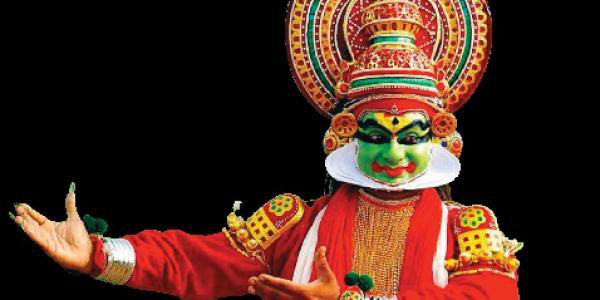

In [6]:
Image.open(TRAIN_DIR+'/234.jpg')

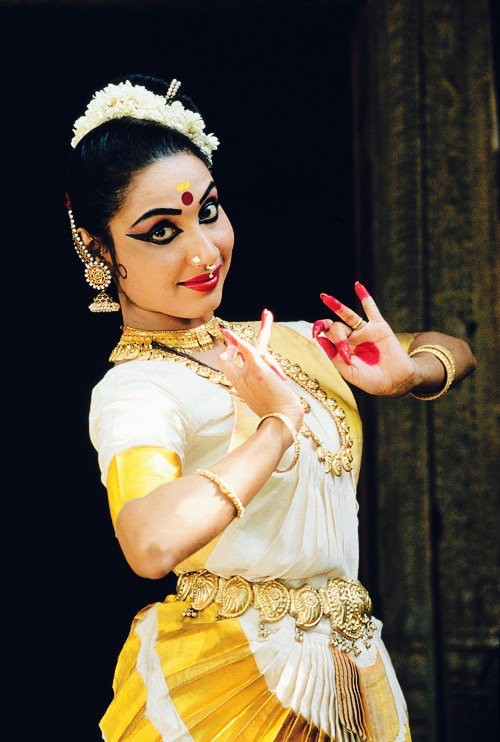

In [7]:
Image.open(TRAIN_DIR+'/287.jpg')

**Q: What is the total no of images?**

In [8]:
len(os.listdir(TRAIN_DIR))

364

**To train a classifier we need labels which is given in TRAIN_CSV file. Each images is mapped with their labels in this file. Let's look at this file.**

In [9]:
train_df = pd.read_csv(TRAIN_CSV)
train_df.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


**Q: what is the total no of images belongs to each class?**

In [10]:
train_df.target.value_counts()

mohiniyattam     50
odissi           49
bharatanatyam    47
kathakali        47
kuchipudi        46
sattriya         45
kathak           44
manipuri         36
Name: target, dtype: int64

<a id = 'dist'></a>
### Dataset Distribution and Pre-processing

I will use fastai datablock to make dataset and dataloader which I've learn recently through fastbook. If you want to learn Machine Learning this is the best resourse. Visit [fast.ai](http://fast.ai) for more information.

In [11]:
def get_x(r): return DATA_DIR+'/train/'+r['Image']  # Image Directory
def get_y(r): return r['target']                    # Getting the label
dblock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    splitter=RandomSplitter(),
    get_x = get_x,
    get_y = get_y,
    item_tfms = Resize(330),
    batch_tfms=aug_transforms(mult=2))

dls = dblock.dataloaders(train_df)

train_dl = dls.train
valid_dl = dls.valid

**Let's look a batch of dataset**

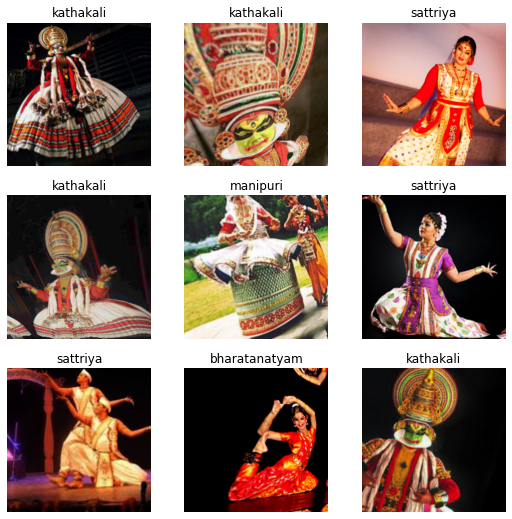

In [12]:
dls.show_batch()

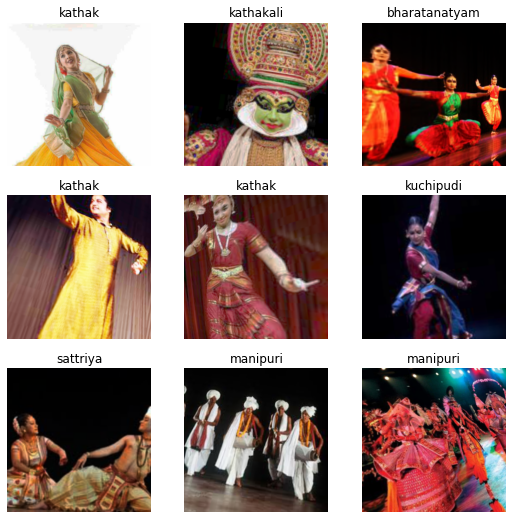

In [13]:
dls.train.show_batch()

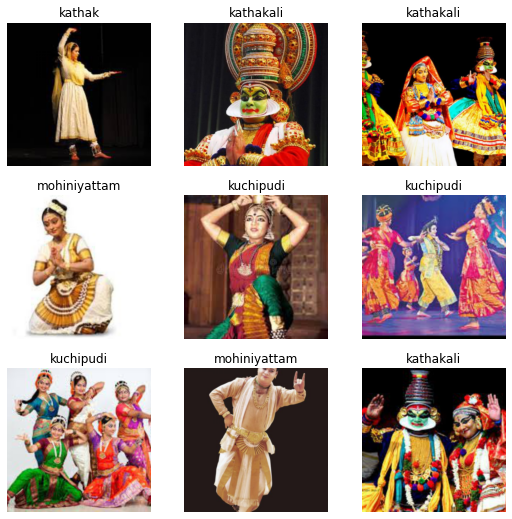

In [14]:
dls.valid.show_batch()

<a id="part-b"></a>
## Classification Algorithms
A classification model tries to draw some conclusion from the input values given for training. It will predict the class labels/categories for the new data.

Here we are going to prepare several Classification machine learning models based on those we will do a comparative analysis that which model is better among them.

A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. In this sense, neural networks refer to systems of neurons, either organic or artificial in nature. Neural networks can adapt to changing input; so the network generates the best possible result without needing to redesign the output criteria. The concept of neural networks, which has its roots in artificial intelligence, is swiftly gaining popularity in the development of trading systems.

Here I am going to use two different Neural Network Algorithms for deploying the models. They are -

1. **Feed Forward Neural Network** : Signals travel in one way i.e. from input to output only in Feed forward Neural Network. There is no feedback or loops. The output of any layer does not affect that same layer in such networks. Feed forward neural networks are straight forward networks that associate inputs with outputs. They have fixed inputs and outputs. They are mostly used in pattern generation, pattern recognition and classification.


2. **Transfer Learning** : Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task. It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems.

Let's get into the algorithms and model deployment...


In [16]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [17]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

<a id = 'feed'></a>
### Feed Forward Neural Network

Let's create a base model class, which contains everything except the model architecture i.e. it wil not contain the __init__ and __forward__ methods. We will later extend this class to try out different architectures. In fact, you can extend this model to solve any image classification problem.

![](https://msatechnosoft.in/blog/wp-content/uploads/2018/05/feed-forward-neural-network-MSA-Technosoft.png)

In [18]:
class DanceModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 512)  # first linear layer
        self.linear2 = nn.Linear(512, 128)          # second linear layer
        self.linear3 = nn.Linear(128, output_size)  # third linear layer

        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        
        out = self.linear2(out)
        out = F.relu(out)
        
        out = self.linear3(out)
        return out

**Model Creation for Feed Forward Neural Network**

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [20]:
device = get_default_device()
print(device)

# image size is 224x224x3 
# output class = 8
input_size = 330*330*3
output_size = 8
model = to_device(DanceModel(), device)

cuda


Before you train the model, it's a good idea to check the validation loss & accuracy with the initial set of weights.

In [21]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.0768256187438965, 'val_acc': 0.1640625}]

**Train the model using the fit function to reduce the validation loss & improve accuracy.**

In [22]:
history += fit(5, 1e-3, model, train_dl, valid_dl)

Epoch [0], val_loss: 2.0735, val_acc: 0.1875
Epoch [1], val_loss: 2.0644, val_acc: 0.2891
Epoch [2], val_loss: 2.0714, val_acc: 0.1328
Epoch [3], val_loss: 2.0584, val_acc: 0.2109
Epoch [4], val_loss: 2.0683, val_acc: 0.1094


In [23]:
history += fit(5, 1e-2, model, train_dl, valid_dl)

Epoch [0], val_loss: 2.0676, val_acc: 0.1250
Epoch [1], val_loss: 2.0503, val_acc: 0.1719
Epoch [2], val_loss: 2.0629, val_acc: 0.0547
Epoch [3], val_loss: 2.0296, val_acc: 0.1484
Epoch [4], val_loss: 2.0706, val_acc: 0.1484


**Let us also define a couple of helper functions for plotting the losses & accuracies.**

In [24]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

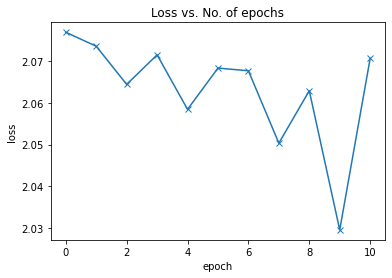

In [25]:
plot_losses(history)

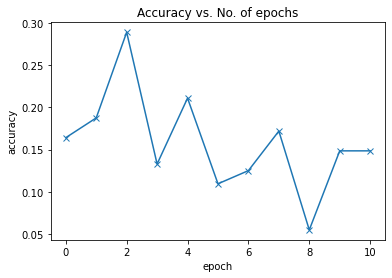

In [26]:
plot_accuracies(history)

<a id = 'tf'></a>
### Transfer Learning
In transfer learning, we try to transfer as much knowledge as possible from the previous task the model was trained on to the new task at hand. This knowledge can be in various forms depending on the problem and the data. For example, it could be how models are composed, which allows us to more easily identify novel objects.

![](https://www.topbots.com/wp-content/uploads/2019/12/cover_transfer_learning_1600px_web.jpg)

In [36]:
class DanceResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
#         self.network = models.resnet34(pretrained=True)
        self.network = models.resnet50(pretrained=True)
        
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

**Training the model using the train.csv data**

In [37]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

**Model Creation for Transfer Learning Neural Network**

In [38]:
device = get_default_device()
print(device)
model = to_device(DanceResnet(), device)

cuda


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


**Train the model using the fit function to reduce the validation loss & improve accuracy.**

In [39]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.273252248764038, 'val_acc': 0.1015625}]

In [40]:
model.freeze()

In [41]:
epochs = 5
max_lr =  1e-3
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [42]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], val_loss: 2.0638, val_acc: 0.4141



Epoch [1], val_loss: 1.9512, val_acc: 0.4375



Epoch [2], val_loss: 2.0008, val_acc: 0.3906



Epoch [3], val_loss: 1.9488, val_acc: 0.4375



Epoch [4], val_loss: 1.8078, val_acc: 0.6719
CPU times: user 8.34 s, sys: 5.78 s, total: 14.1 s
Wall time: 41.8 s


In [43]:
model.unfreeze()

In [44]:
%%time
history += fit_one_cycle(5, 1e-4, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], val_loss: 1.7070, val_acc: 0.7109



Epoch [1], val_loss: 1.6342, val_acc: 0.8438



Epoch [2], val_loss: 1.6095, val_acc: 0.9062



Epoch [3], val_loss: 1.6000, val_acc: 0.9219



Epoch [4], val_loss: 1.5974, val_acc: 0.9062
CPU times: user 7.98 s, sys: 5.39 s, total: 13.4 s
Wall time: 41.3 s


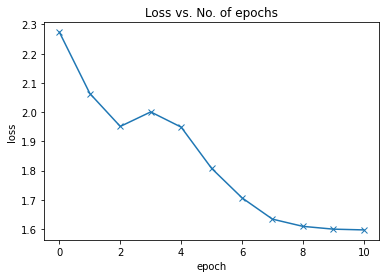

In [45]:
plot_losses(history)

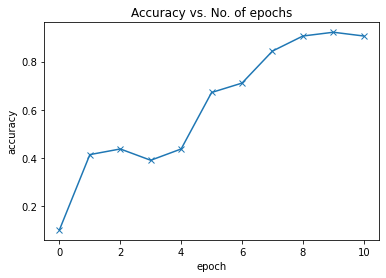

In [46]:
plot_accuracies(history)

****************

<a id = 'conclusion'></a>
## Conclusion and Comparison
We have deployed two deep learning algorithms and every algorithm is deployed successfully without any hesitation. We have checked the accuracy of the models based on the accuracy score of each of the models. Now let's take a look at the scores of each models.

|Name of the Model|Accuracy Score|
|:---:|:---:|
|Feed Forward Neural Network|0.17|
|Transfer Learning Neural Network|0.91|


**Comparing all those scores scored by the deep learning algorithms, it is clear that Transfer Learning Neural Network is having the upper hand in case of this dataset.**

Best Fitted Models ranking - 
1. Transfer Learning Neural Network
2. Feed Forward Neural Network

Hooray!! The models are deployed successfully!


### Hope this project will help you! Thank you!